In [1]:
# Imports

import numpy as np
import pandas as pd
import os, os.path
from itertools import *
%matplotlib inline
import matplotlib.pyplot as plt
import math
import random
import scipy.stats

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent data retrieval script

chromosomes = [1, 2, 6, 7, 11]
def chromosome_files(n):
    base = 'intersected_final_chr'
    spec = '_cutoff_20_'
    suffixes = ['train.bed', 'sample_partial.bed', 'sample_full.bed']
    return [base + str(n) + spec + suffix for suffix in suffixes]
all_files = set(chain.from_iterable(chromosome_files(n) for n in chromosomes))

if 'methylation_imputation' not in [x for x in os.listdir('.') if os.path.isdir(x)]:
    raise Exception('Missing assignment repository in cwd')

if not os.path.exists('data'):
    os.mkdir('data')

def all_files_present(): return all_files.issubset(set(os.listdir('data')))
if not all_files_present():
    ! gunzip -k methylation_imputation/data/*.bed.gz
    ! mv methylation_imputation/data/*.bed data/
    if not all_files_present():
        raise Exception('Error unpacking data')

def read_tsv(name): return pd.read_csv(name, sep='\t', header=None)
train_chr1 = read_tsv('data/' + chromosome_files(1)[0])
test_chr1_partial = read_tsv('data/' + chromosome_files(1)[1])
test_chr1_full = read_tsv('data/' + chromosome_files(1)[2])

unknown_chr1_ix = np.where((test_chr1_partial[5] == 0) & ~np.isnan(test_chr1_full[4]))[0]
known_chr1_ix = np.where((test_chr1_partial[5] == 1) & ~np.isnan(test_chr1_partial[4]))[0]

train_df = train_chr1
train_chromosomes = ['b' + str(x) for x in range(train_chr1.shape[1] - 4)]
train_df.columns = ['chromosome', 'start', 'end', 'strand'] + train_chromosomes

test_df = test_chr1_full
test_df.columns = ['chromosome', 'start', 'end', 'strand', 'filled', 'assayed']
test_df['missing'] = test_chr1_partial[4]

In [2]:
train_df.loc[range(267, 273)]

,chromosome,start,end,strand,b0,b1,b2,b3,b4,b5,...,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33
267,chr1,121511,121513,+,0.714286,0.739130,0.800000,0.782609,0.794872,0.750000,...,0.860465,0.789474,NaN,0.727273,0.896552,0.810811,0.809524,0.842105,0.880000,0
268,chr1,121516,121518,+,0.857143,0.800000,0.833333,0.913043,0.909091,0.806452,...,0.931818,0.888889,NaN,0.840000,0.862069,0.756757,0.916667,0.833333,0.916667,0
269,chr1,122736,122738,-,0.545455,0.384615,0.472727,NaN,0.436364,0.580000,...,0.487179,NaN,NaN,NaN,0.413043,0.462963,0.533333,0.659574,0.682927,0
270,chr1,122869,122871,-,0.837838,0.814815,0.725000,0.807692,0.710526,0.565217,...,0.629630,NaN,NaN,NaN,0.755556,0.590909,0.681818,0.657143,NaN,0
271,chr1,122884,122886,-,0.842105,0.821429,0.720930,0.800000,0.795455,0.478261,...,0.617021,NaN,NaN,NaN,0.682927,0.562500,0.739130,0.666667,0.756098,0
272,chr1,127749,127751,+,0.633333,0.473684,0.703704,0.611111,0.827586,0.666667,...,0.782609,0.800000,NaN,0.812500,0.500000,0.812500,0.840909,0.687500,0.807692,0


In [3]:
assert len(train_df) == len(test_df)
def count_unique(col):
    return {x:sum(col == x) for x in set(col)}

print('Chromosome 1')
print('Total samples', len(train_df))
print('Site lengths', count_unique(train_df['end'] - train_chr1['start']))
print('Strand types', count_unique(train_df['strand']))
print('Known (test) sample site counts', len(known_chr1_ix))
print('Unknown (test) sample site counts', len(unknown_chr1_ix))
print('NaN ratio in all train samples',
      sum(sum(np.isnan(train_df[train_chromosomes].values))) / (len(train_df) * len(train_chromosomes)))
print('NaN ratio in test', sum(np.isnan(test_df['missing'])) / len(test_df))
assert sum(test_df['strand'] != train_df['strand']) == 0

Chromosome 1
Total samples 379551
Site lengths {2: 379551}
Strand types {'+': 378087, '-': 1464}
Known (test) sample site counts 7523
Unknown (test) sample site counts 368411
NaN ratio in all train samples 0.0849950103582
NaN ratio in test 0.980179211753


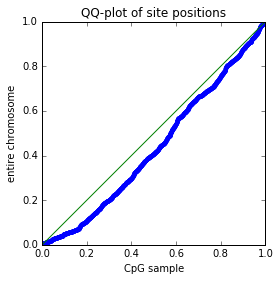

avg length between known sites 50.2903483116
sd of number of bp between sites 86.9614546017


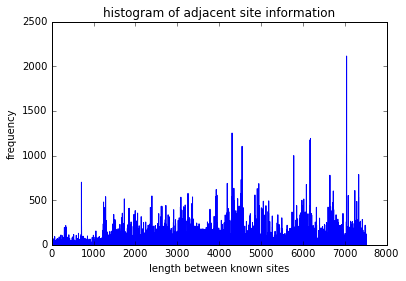

In [4]:
# Make sure our samples are pretty uniform from the genomic range
def ticks(n): return np.arange(0.0, n) / n
plt.plot(ticks(len(known_chr1_ix)), known_chr1_ix / len(train_df), '.')
plt.plot([0, 1])
plt.axes().set_aspect('equal')
plt.xlabel('CpG sample')
plt.ylabel('entire chromosome')
plt.title('QQ-plot of site positions')
plt.show()

diffs = np.diff(known_chr1_ix)
print('avg length between known sites', np.mean(diffs))
print('sd of number of bp between sites', np.std(diffs))
plt.plot(np.diff(known_chr1_ix))
plt.xlabel('length between known sites')
plt.ylabel('frequency')
plt.title('histogram of adjacent site information')
plt.show()

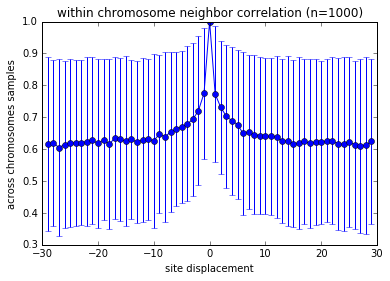

In [5]:
# Observe nearby site correlations
def drop_nan_corr(x, y):
    ix = np.where(~np.isnan(y) & ~np.isnan(x))
    return scipy.stats.pearsonr(x[ix], y[ix])[0]
# Choose a random site, check neighbors within vicinity of 'reach'
reach = list(range(30))
reach = [-x for x in reversed(reach)] + reach[1:]
def sample_corr(reach):
    site = random.randint(max(reach), len(train_chr1) - max(reach) - 1)
    y = np.array(train_df.iloc[site][train_chromosomes]
                 .values).astype(np.float64)
    nbrs = [site + i for i in reach]
    xs = np.array(train_df.iloc[nbrs][train_chromosomes]
                  .values).astype(np.float64)
    return np.array([drop_nan_corr(x, y) for x in xs])

sample = 1000
test = np.array([sample_corr(reach) for i in range(sample)])
plt.errorbar(reach, np.mean(test, axis=0), fmt='-o', yerr=np.std(test, axis=0))
plt.title('within chromosome neighbor correlation (n={})'.format(sample))
plt.ylabel('across chromosomes samples')
plt.xlabel('site displacement')
plt.show()

orig : rolling mean stddevs 4.82644303914


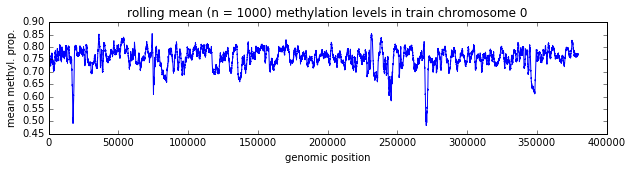

In [6]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

x = local_impute(np.copy(train_df['b0']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
plt.figure(figsize=(10, 2))
print('orig : rolling mean stddevs', np.std(x) / np.std(rolled))
plt.title('rolling mean (n = 1000) methylation levels in train chromosome 0')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')
plt.plot(rolled)

In [36]:
# No trends, but clearly we can impute from local neighbor data.
# Try using no information for our test chromosome as a baseline.
def pandas_rmse(attempt):
    # http://stackoverflow.com/questions/27783494/root-mean-square-error-of-two-pandas-series
    diff = attempt.iloc[unknown_chr1_ix].sub(test_df['filled'].iloc[unknown_chr1_ix])
    return math.sqrt(diff.pow(2).mean())
def correct_half(attempt):
    methylated_guess = attempt.iloc[unknown_chr1_ix] >= 0.5
    methylated_exact = test_df['filled'].iloc[unknown_chr1_ix] >= 0.5
    return sum(methylated_guess == methylated_exact) / len(methylated_guess)

interpolation_fill = local_impute(test_df['missing'].copy())
def eval(x): print('rmse', pandas_rmse(x), 'methylation acc', correct_half(x))
print('interpolation')
eval(interpolation_fill)

print('mean from known beta')
eval(pd.Series(np.full(len(test_df), np.mean(test_df['filled'][known_chr1_ix]))))

print('overfit mean from unknown beta')
eval(pd.Series(np.full(len(test_df), np.mean(test_df['filled'][unknown_chr1_ix]))))

print('train std', np.std(test_df['filled'][known_chr1_ix]),
      'test std',  np.std(test_df['filled'][unknown_chr1_ix]))

interpolation
rmse 0.237903813067756 methylation acc 0.84662781513
mean from known beta
rmse 0.179393104914703 methylation acc 0.932664876999
overfit mean from unknown beta
rmse 0.1691002902217554 methylation acc 0.932664876999
train std 0.2363237974 test std 0.169100290222


In [8]:
# Site-dependent information seems to do a bit better:
eval(train_df[train_chromosomes].mean(axis=1))

rmse 0.12896690356184323 methylation acc 0.952914000939


In [9]:
s = 1 / 20 # choice is important! need cross-val for 'proper' selection.
# However, this confirms the interpolation does provide some valuable info as well 
# How to combine intelligently? It can't just be a feature (else we have a perfect predictor)
eval((train_df[train_chromosomes].mean(axis=1) + interpolation_fill * s) / (1+s))

rmse 0.12801121053064327 methylation acc 0.954903626656


In [10]:
# closest-filter on input data; other chromosomes -> glm (cross val on 33)
train_strands = np.array((train_chr1[STRAND_TYPE] == '+').values).astype(np.float64)
train_betas = train_chr1.as_matrix(TRAIN_COLS).astype(np.float64)
train_betas = np.apply_along_axis(local_impute, 1, train_betas)
X = np.hstack((train_betas, train_strands.reshape(len(train_strands), 1)))
print('X shape', X.shape)
Y = np.array(test_chr1_full[TEST_COL].values).astype(np.float64)
trainX, trainY = X[known_chr1_ix], Y[known_chr1_ix]
testX, testY = X[unknown_chr1_ix], Y[unknown_chr1_ix]

# logistic and linear regression from sklearn here. try poly features. Try adding interpolated info?

# Beta as a first-run
#sm.GLM(trainX, trainY, )
# eval how out-of sample we are with the explanatory variables (extrapolation not interp)

# rf regression
# cluster-based glm decision tree -> 4 clusters (GMM), then glm (or rf)
# verify cluster hypothesis (GMM likelihood over K)
# Add encode data

NameError: name 'STRAND_TYPE' is not defined

In [11]:
# Annoying R interfacing for beta regression
# https://sites.google.com/site/aslugsguidetopython/data-analysis/pandas/calling-r-from-python

# TODO rm extra imports
#from numpy import *
#import scipy as sp
#from pandas import *
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# Do local imputation on our training data
train_df_interp = train_df
for i in train_chromosomes:
    train_df_interp[i] = local_impute(train_df[i].copy())
train_rdf = com.convert_to_r_dataframe(train_df)
test_rdf = com.convert_to_r_dataframe(test_df)

In [12]:
ro.globalenv['train_rdf'] = train_rdf
ro.globalenv['test_rdf'] = test_rdf
ro.globalenv['train_ix'] = known_chr1_ix + 1
ro.globalenv['test_ix'] = unknown_chr1_ix + 1

In [22]:
rcmd = 'lm(test_rdf$filled ~ ' + ' + '.join(train_chromosomes) + ', data=train_rdf, subset=train_ix)'
ro.r('fit <- ' + rcmd)
print(ro.r('summary(fit)'))


Call:
lm(formula = test_rdf$filled ~ b0 + b1 + b2 + b3 + b4 + b5 + 
    b6 + b7 + b8 + b9 + b10 + b11 + b12 + b13 + b14 + b15 + b16 + 
    b17 + b18 + b19 + b20 + b21 + b22 + b23 + b24 + b25 + b26 + 
    b27 + b28 + b29 + b30 + b31 + b32 + b33, data = train_rdf, 
    subset = train_ix)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.289417 -0.033576  0.002631  0.035622  0.312194 

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0144293  0.0046838  -3.081  0.00207 ** 
b0          -0.0077533  0.0094089  -0.824  0.40994    
b1           0.0167026  0.0087456   1.910  0.05619 .  
b2          -0.0068301  0.0092724  -0.737  0.46138    
b3          -0.0092217  0.0083037  -1.111  0.26680    
b4          -0.0598107  0.0074321  -8.048 9.74e-16 ***
b5           0.0129791  0.0091790   1.414  0.15740    
b6           0.0610099  0.0105800   5.767 8.41e-09 ***
b7           0.0074064  0.0071773   1.032  0.30

In [30]:
rpred = 'predict(fit, train_rdf[test_ix,])'
rexact = 'test_rdf[test_ix,]$filled'
print('lm rmse', ro.r('sqrt(mean((' + rpred + '-' + rexact + ') ^ 2))'))
ro.r('linear_coef <- coef(fit)')
ro.r('linear_coef[length(linear_coef)] = 0')
ro.r('linear_coef')
# TODO: does this match python lm?

lm rmse [ 0.05964656]


array([ -1.44293357e-02,  -7.75333075e-03,   1.67026215e-02,
        -6.83014508e-03,  -9.22171507e-03,  -5.98106731e-02,
         1.29791383e-02,   6.10099098e-02,   7.40638950e-03,
         1.72678097e-02,   1.75063144e-02,  -6.46676632e-03,
         6.66095757e-03,  -7.66177542e-03,  -9.90022293e-04,
        -4.95296254e-03,   4.45678584e-03,  -1.67357579e-03,
         3.20081153e-03,  -2.66928293e-02,   5.92189845e-01,
         1.03804344e-01,   9.75717545e-02,   1.12664918e-01,
         4.16979418e-02,  -5.09076914e-02,   2.55401900e-04,
         9.15506232e-03,   2.04393514e-03,  -8.16984509e-03,
         9.69442906e-03,  -1.78446537e-03,   9.70780300e-02,
        -3.60613238e-03,   0.00000000e+00])

In [32]:
# model doesn't like sample b33
importr('betareg')
rcmd = 'betareg(test_rdf$filled ~ ' + ' + '.join(train_chromosomes[:-1]) + \
    ', data=train_rdf, subset=train_ix' + \
    ', start=list(mean=head(linear_coef, -1), precision=1))'
ro.r('fit <- ' + rcmd)
print(ro.r('summary(fit)'))
rpred = 'predict(fit, train_rdf[test_ix,])'
rexact = 'test_rdf[test_ix,]$filled'
print(ro.r('sqrt(mean((' + rpred + '-' + rexact + ') ^ 2))'))


Call:
betareg(formula = test_rdf$filled ~ b0 + b1 + b2 + b3 + b4 + b5 + b6 + 
    b7 + b8 + b9 + b10 + b11 + b12 + b13 + b14 + b15 + b16 + b17 + b18 + 
    b19 + b20 + b21 + b22 + b23 + b24 + b25 + b26 + b27 + b28 + b29 + 
    b30 + b31 + b32, data = train_rdf, subset = train_ix, start = list(mean = head(linear_coef, 
    -1), precision = 1))

Standardized weighted residuals 2:
    Min      1Q  Median      3Q     Max 
-4.2495 -0.6295  0.0209  0.6730  5.6485 

Coefficients (mean model with logit link):
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.704774   0.031578 -85.654  < 2e-16 ***
b0          -0.146542   0.063241  -2.317 0.020493 *  
b1           0.146284   0.058725   2.491 0.012738 *  
b2          -0.053934   0.061910  -0.871 0.383666    
b3          -0.013670   0.056092  -0.244 0.807462    
b4          -0.278414   0.046823  -5.946 2.75e-09 ***
b5           0.084957   0.057229   1.485 0.137674    
b6           0.228480   0.066530   3.434 0.000594 ***
b7    